In [1]:
import numpy as np
import pandas as pd
from zipfile import ZipFile
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from math import sqrt

## Data Wrangling

In [2]:
message_cols = ["Time(sec)", "Event Type", "Order ID", "Size", "Price", "Direction", "N/A"]
order_cols = ["Ask Price1", "Ask Size1", "Bid Price1", "Bid Size1", "Ask Price2", "Ask Size2", \
             "Bid Price2", "Bid Size2"]

In [3]:
zip_file = ZipFile('MM-2022-Coursework-Data.zip')

message_dfs = {csv_file.filename: pd.read_csv(zip_file.open(csv_file.filename), names = message_cols)
       for csv_file in zip_file.infolist()
       if csv_file.filename.endswith('message_2.csv')}

# order_dfs = {csv_file.filename: pd.read_csv(zip_file.open(csv_file.filename), names = order_cols)
#        for csv_file in zip_file.infolist()
#        if csv_file.filename.endswith('order_2.csv')}

C:\Users\jamie\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


## Question 4

In [7]:
#regular acf, can use for intra-day

def acf(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
        for i in range(1, length)])

In [60]:
#now start interday stuff
csv_titles = list(message_dfs.keys())
indexes = np.array([0.])
x = np.array([])
for title in csv_titles:
    #print(len(message_dfs[title]['Direction']))
    indexes = np.append(indexes, indexes[-1]+len(message_dfs[title]['Direction']))
    x = np.append(x, message_dfs[title]['Direction'].to_numpy())

In [10]:
print('average number of orders', len(x)/len(csv_titles))

average number of orders 258277.1


In [61]:
# empirical autocorrelation (avoid spanning sequences) inter-day

def acov_sums(x, max_lags=20):
    '''computes sample autocovariances of x, assuming x has had mean subtracted already'''
    return np.convolve(x, x[::-1])[len(x)-1:len(x)+max_lags] / len(x)

def acf_interday(x, indexes, max_lags=20):
    x = x - np.mean(x)
    cov_sum = np.zeros(max_lags+1)
    div = np.ones(max_lags+1)*indexes[-1] - (len(indexes)-1)*np.linspace(0, max_lags, max_lags+1)
    for i in range(len(indexes)-1):
        start, end = int(indexes[i]), int(indexes[i+1]+1.)
        cov_sum += acov_sums(x[start:end], max_lags)
    cov_sum = cov_sum / div
    return cov_sum / cov_sum[0]

In [62]:
acf_jan = acf_interday(x, indexes, max_lags=100)

In [63]:
acf_jan

array([1.        , 0.34833148, 0.25304026, 0.21532046, 0.19177876,
       0.17679659, 0.16565448, 0.15748184, 0.15131656, 0.14467775,
       0.13791818, 0.13151593, 0.12583777, 0.12059731, 0.11602156,
       0.11109578, 0.10793819, 0.10380434, 0.10102447, 0.09766083,
       0.09522224, 0.09213952, 0.08886908, 0.08642472, 0.08510011,
       0.08232451, 0.07945341, 0.07761498, 0.07511952, 0.07347048,
       0.07126068, 0.06981848, 0.06844389, 0.06696536, 0.06469596,
       0.06332615, 0.0626846 , 0.06129814, 0.06003037, 0.05923166,
       0.05779434, 0.05683657, 0.05547242, 0.05493504, 0.05340099,
       0.05255728, 0.05079676, 0.05058196, 0.0502438 , 0.05012416,
       0.04901276, 0.04812551, 0.04727756, 0.04671803, 0.04482642,
       0.04472299, 0.0433684 , 0.04387678, 0.04332795, 0.04197409,
       0.04083378, 0.04026309, 0.04068692, 0.03907204, 0.038471  ,
       0.03850157, 0.03818409, 0.03687957, 0.03619045, 0.03630648,
       0.03576556, 0.03569848, 0.03494937, 0.03441638, 0.03421

In [64]:
#function to plot acfs

def plot_acf(acf, n=None, CI=None, title=None, save=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(16.5, 8.5)
    x = np.linspace(0, len(acf)-1, len(acf))
    ax.stem(x, acf, linefmt='C1-', markerfmt='C1o', basefmt='C1-')
    if CI=='eff':
        eff_samp_size = n*((1-acf[1])/(1+acf[1]))
        plt.axhline(y=1/sqrt(eff_samp_size), color='C0', linestyle='--')
    elif CI=='N':
        plt.axhline(y=1/sqrt(n), color='C0', linestyle='--')
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.title(title)
    plt.savefig(save, dpi=600)
    plt.show()

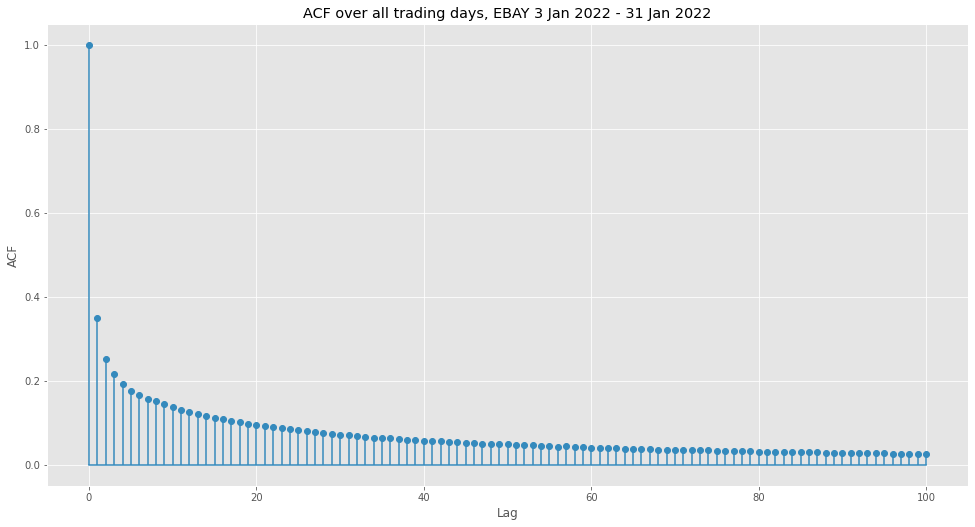

In [65]:
plot_acf(acf_jan, CI=None, title='ACF over all trading days, EBAY 3 Jan 2022 - 31 Jan 2022', save='ACF_all')

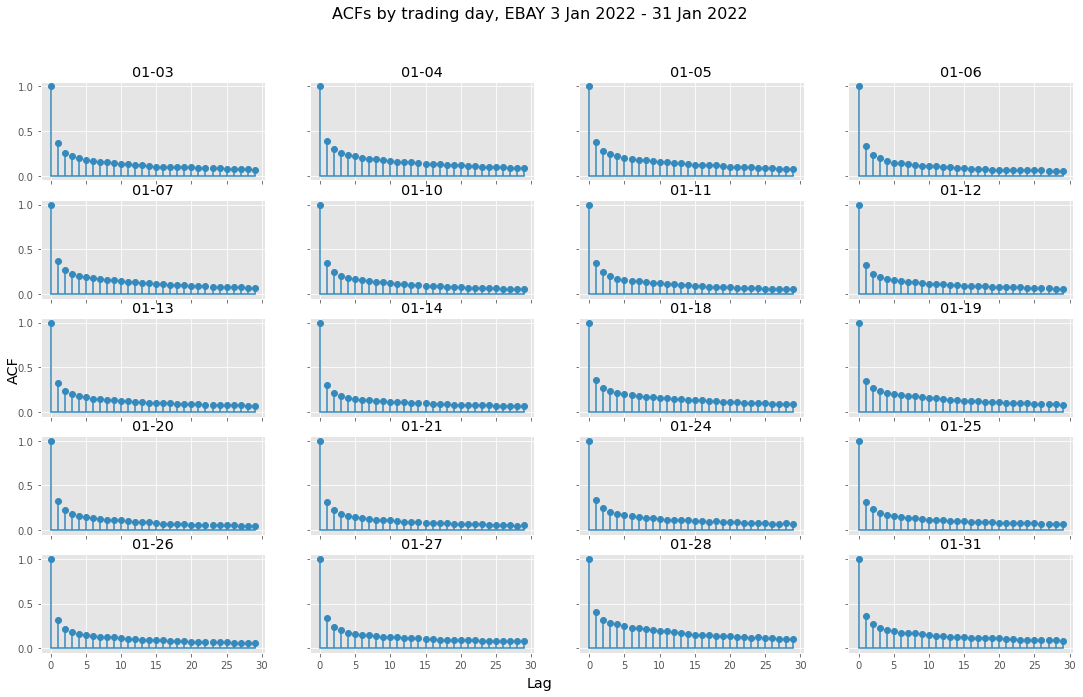

In [58]:
#plot multiple ACFs
len(csv_titles)

fig, axs = plt.subplots(5, 4, sharex=True, sharey=True)
fig.set_size_inches(18.5, 10.5)
fig.suptitle('ACFs by trading day, EBAY 3 Jan 2022 - 31 Jan 2022', fontsize=16)

for i in range(len(csv_titles)):
    n = len(message_dfs[csv_titles[i]]['Direction'])
    acf_ = acf(message_dfs[csv_titles[i]]['Direction'], length=30)
    x = np.linspace(0, len(acf_)-1, len(acf_))
    axs[i//4, i%4].stem(x, acf_, linefmt='C1-', markerfmt='C1o', basefmt='C1-')
    #axs[i//5, i%5].axhline(y=1/sqrt(n), color='C0', linestyle='--')
    axs[i//4, i%4].set_title(csv_titles[i][10:15])

fig.text(0.5, 0.08, 'Lag', ha='center', fontsize='x-large')
fig.text(0.1, 0.5, 'ACF', va='center', rotation='vertical', fontsize='x-large')
fig.savefig('ACF_sep_days', dpi=600)

In [17]:
#plot by event type
csv_titles = list(message_dfs.keys())
events_dict = dict()

#prep dict
for event_type in range(1,8):
    events_dict[event_type] = {'x':[], 'ind':[0.]}

#loop
for event_type in range(1, 8):
    for title in csv_titles:
        df = message_dfs[title][message_dfs[title]['Event Type']==event_type]
        
        events_dict[event_type]['x'] = np.append(events_dict[event_type]['x'], df['Direction'].to_numpy())
        events_dict[event_type]['ind'] = np.append(events_dict[event_type]['ind'], events_dict[event_type]['ind'][-1] + len(df['Direction']))

In [28]:
for event_type in range(1, 8):
    events_dict[event_type]['ACF'] = acf_interday(events_dict[event_type]['x'], events_dict[event_type]['ind'], max_lags=30)

<ipython-input-12-7590e1ab497e>:15: RuntimeWarning: invalid value encountered in true_divide
  return cov_sum / cov_sum[0]


ValueError: operands could not be broadcast together with shapes (31,) (2,) (31,) 

In [30]:
events_dict

{1: {'x': array([-1., -1., -1., ...,  1., -1.,  1.]),
  'ind': array([      0.,   84261.,  204632.,  367582.,  486488.,  574276.,
          685846.,  775700.,  883796., 1011147., 1160960., 1335518.,
         1491197., 1618484., 1817938., 1886373., 2092935., 2319843.,
         2439912., 2457669., 2508770.]),
  'ACF': array([1.        , 0.49440019, 0.37973341, 0.32062791, 0.28078369,
         0.25021557, 0.22559315, 0.20509109, 0.18836052, 0.17278036,
         0.16017829, 0.14860143, 0.13878071, 0.12884634, 0.11967022,
         0.11250222, 0.10625638, 0.09997267, 0.09557487, 0.09090888,
         0.08668388, 0.08218098, 0.07825121, 0.07495667, 0.07265948,
         0.06984641, 0.06791238, 0.06528941, 0.0620751 , 0.06034267,
         0.0582951 ])},
 2: {'x': array([ 1.,  1.,  1., ..., -1.,  1.,  1.]),
  'ind': array([   0.,  114.,  343.,  410.,  938., 1010., 1544., 1620., 1763.,
         1866., 2783., 2861., 2976., 4820., 4911., 4952., 5047., 5734.,
         6208., 6208., 7380.]),
  'ACF': 

In [40]:
event_titles = {1: 'Submission of a new limit order', 2: 'Cancellation (partial deletion of a limit order)', 3: 'Deletion (total deletion of a limit order)', 4: 'Execution of a visible limit order', 5: 'Execution of a hidden limit order', 6: 'Indicates a cross trade, e.g. auction trade', 7: 'Trading halt indicator (detailed information below)'}

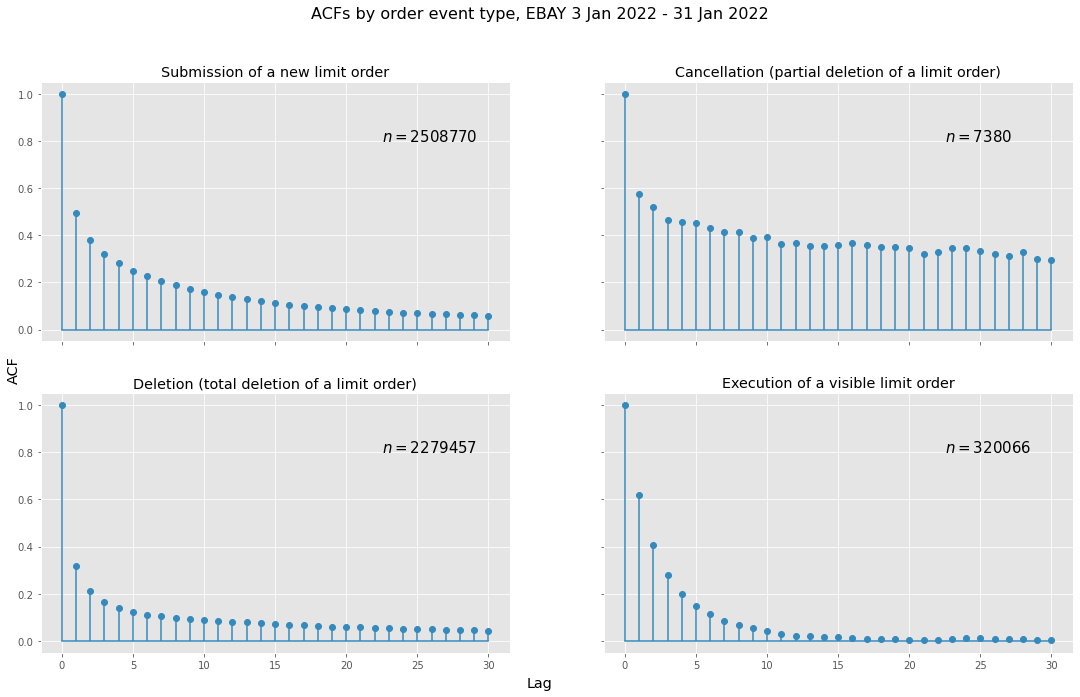

In [56]:
#plot by event type
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(18.5, 10.5)
fig.suptitle('ACFs by order event type, EBAY 3 Jan 2022 - 31 Jan 2022', fontsize=16)

for i in range(4):
    acf_ = events_dict[i+1]['ACF']
    x = np.linspace(0, len(acf_)-1, len(acf_))
    axs[i//2, i%2].stem(x, acf_, linefmt='C1-', markerfmt='C1o', basefmt='C1-')
    #axs[i//5, i%5].axhline(y=1/sqrt(n), color='C0', linestyle='--')
    axs[i//2, i%2].set_title(event_titles[i+1])
    axs[i//2, i%2].text(22.5, .8, r'$n=$'+str(int(events_dict[i+1]['ind'][-1])), fontsize=15)

fig.text(0.5, 0.08, 'Lag', ha='center', fontsize='x-large')
fig.text(0.1, 0.5, 'ACF', va='center', rotation='vertical', fontsize='x-large')
fig.savefig('ACF_event_type', dpi=600)